### 1. Imports and Setup
Imports necessary libraries for data manipulation, modeling, and visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 2. Data Loading
Loads the cleaned trip data from the parquet file.

In [2]:
# First load the cleaned dataframe
df = pd.read_parquet('../Trips_2018_cleaned.parquet')
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,7.0,13.0
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,7.0,7.0
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,7.0,7.0
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,7.0,7.0
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,7.0,5.0


### 3. Time Grid Construction
Creates a "skeleton" DataFrame containing every combination of hour and cluster for the entire year to ensure a continuous time series.

In [3]:
# We need to prepare the data for the Random Forest model

# First we define the time range for the whole year (2018)
# We use 'H' for hourly frequency
time_range = pd.date_range(start='2018-01-01', end='2018-12-31 23:00:00', freq='h')

# Get the list of unique clusters from the df
unique_clusters = df['start_cluster'].unique()
unique_clusters = unique_clusters[~np.isnan(unique_clusters)] # Safety check to remove NaNs

# 3. Create a MultiIndex (All combinations of Time x Cluster)
# This ensures we have a row for every hour for every cluster
# It gives us a table with approx 175,000 rows (365 days * 24 hours * 20 clusters)
import itertools
index = pd.MultiIndex.from_product([time_range, unique_clusters], names=['datetime', 'cluster_id'])

# Create the empty DataFrame
df_model = pd.DataFrame(index=index).reset_index()

print(f"Skeleton created with {len(df_model)} rows.")
df_model.head()


Skeleton created with 175200 rows.


,datetime,cluster_id
0,2018-01-01,7.0
1,2018-01-01,15.0
2,2018-01-01,6.0
3,2018-01-01,17.0
4,2018-01-01,3.0


### 4. Data Aggregation
Aggregates raw trip data into the hourly skeleton, filling missing hours with zero activity.

In [4]:
# So basically we only have a skeleton that has all the combinations of hours and clusters for a whole year

# Now we need to fill in the pickups and dropoffs for each hour and cluster

# Convert starttime and stoptime to datetime objects first
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Floor the time to the nearest hour so we can group by hour
df['start_hour'] = df['starttime'].dt.floor('h')

# Counting the pickups
# Group by Time and Cluster, then count
pickups = df.groupby(['start_hour', 'start_cluster']).size().reset_index(name='pickups')
pickups.rename(columns={'start_hour': 'datetime', 'start_cluster': 'cluster_id'}, inplace=True)

# Counting the dropoffs
df['stop_hour'] = df['stoptime'].dt.floor('H')

dropoffs = df.groupby(['stop_hour', 'end_cluster']).size().reset_index(name='dropoffs')
dropoffs.rename(columns={'stop_hour': 'datetime', 'end_cluster': 'cluster_id'}, inplace=True)

# Merge Pickups
df_model = df_model.merge(pickups, on=['datetime', 'cluster_id'], how='left')

# Merge Dropoffs
df_model = df_model.merge(dropoffs, on=['datetime', 'cluster_id'], how='left')

# Important: Fill NaNs with 0, as some hours/clusters have zero activity
# Any hour in the skeleton that didn't match a ride gets a 0 (No activity)
df_model['pickups'] = df_model['pickups'].fillna(0)
df_model['dropoffs'] = df_model['dropoffs'].fillna(0)

print("Aggregation complete.")
df_model.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_7652\2364453129.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['stop_hour'] = df['stoptime'].dt.floor('H')


Aggregation complete.


,datetime,cluster_id,pickups,dropoffs
0,2018-01-01,7.0,11.0,4.0
1,2018-01-01,15.0,10.0,5.0
2,2018-01-01,6.0,4.0,5.0
3,2018-01-01,17.0,1.0,1.0
4,2018-01-01,3.0,19.0,17.0


### 5. Feature Engineering: Calendar
Extracts temporal features (hour, day, month) and creates binary flags for weekends and specific US holidays.

In [5]:
# Next problem is that The Random Forest doesn't understand "2018-01-01". 
# We need to break the date into features it can use to split the trees 
# (e.g., "Is it morning?", "Is it Summer?")

# Extract components
df_model['hour'] = df_model['datetime'].dt.hour
df_model['day_of_week'] = df_model['datetime'].dt.dayofweek # 0=Mon, 6=Sun
df_model['month'] = df_model['datetime'].dt.month

# Add binary flags (Yes/No)
df_model['is_weekend'] = df_model['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# These are dates where bike demand likely changes drastically (commuters stay home)
holiday_list = [
    '2018-01-01', # New Year's Day
    '2018-01-15', # Martin Luther King Jr. Day
    '2018-02-19', # Presidents' Day
    '2018-05-28', # Memorial Day
    '2018-07-04', # Independence Day
    '2018-09-03', # Labor Day
    '2018-10-08', # Columbus Day
    '2018-11-12', # Veterans Day (Observed)
    '2018-11-22', # Thanksgiving Day
    '2018-12-25'  # Christmas Day
]

# Convert string list to date objects
holiday_dates = pd.to_datetime(holiday_list).date

# Create the 'is_holiday' column
# Check if the date part of the timestamp exists in our list
df_model['is_holiday'] = df_model['datetime'].dt.date.isin(holiday_dates).astype(int)


### 6. Feature Engineering: Lags
Generates lagged features (24h and 168h) to capture daily and weekly seasonality, and removes the initial rows where lags are undefined.

In [6]:
# Sort to ensure shifts are correct
df_model.sort_values(['cluster_id', 'datetime'], inplace=True)

# 1. Lag 24h (Yesterday same time)
df_model['lag_24h'] = df_model.groupby('cluster_id')['pickups'].shift(24)

# 2. Lag 1 Week (Last week same time) - Catches "Tuesday patterns"
df_model['lag_168h'] = df_model.groupby('cluster_id')['pickups'].shift(168)

# 3. Clean up
# The first week of data will have NaNs because there is no "last week". We drop them.
df_clean = df_model.dropna()

print(f"Data ready for modeling. Rows: {len(df_clean)}")

Data ready for modeling. Rows: 171840


### 7. Data Inspection
Displays the first few rows of the fully prepared dataset.

In [7]:
df_clean.head()

,datetime,cluster_id,pickups,dropoffs,hour,day_of_week,month,is_weekend,is_holiday,lag_24h,lag_168h
3369,2018-01-08 00:00:00,0.0,0.0,1.0,0,0,1,0,0,1.0,3.0
3389,2018-01-08 01:00:00,0.0,2.0,2.0,1,0,1,0,0,0.0,2.0
3409,2018-01-08 02:00:00,0.0,1.0,0.0,2,0,1,0,0,0.0,3.0
3429,2018-01-08 03:00:00,0.0,0.0,1.0,3,0,1,0,0,0.0,4.0
3449,2018-01-08 04:00:00,0.0,1.0,1.0,4,0,1,0,0,1.0,0.0


### 8. Model Training and Evaluation
Splits the data into training (Jan-Oct) and testing (Nov-Dec) sets, trains a Random Forest Regressor for both pickups and dropoffs, and evaluates performance.

Training Set: 142560 hours
Test Set:     29280 hours

Training Random Forest for: PICKUPS...
Results for pickups:
  MAE (Avg Error):  27.43 bikes
  RMSE (Penalty):   62.04
  Error % (MAE/Avg): 35.3%

Training Random Forest for: DROPOFFS...
Results for dropoffs:
  MAE (Avg Error):  30.29 bikes
  RMSE (Penalty):   65.86
  Error % (MAE/Avg): 39.0%


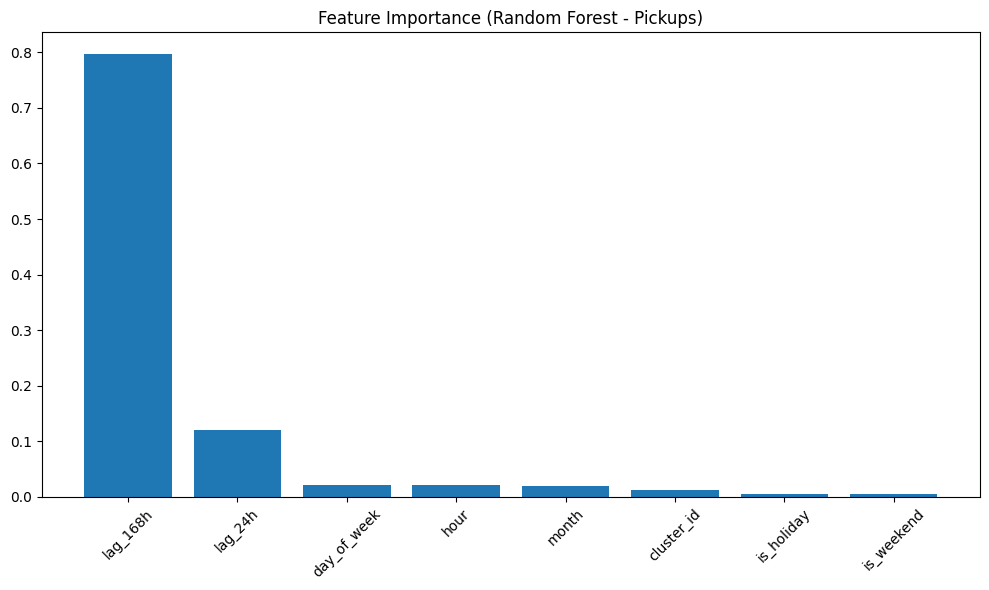


[INFO] Models saved to 'random_forrest_model.joblib'


In [8]:
# We can now finally move to the randoom forrest part

split_date = '2018-11-01' # Use November 1st as the split date as required by pdf

# Features (X)
features = [
    'cluster_id', 'hour', 'day_of_week', 'month', 
    'is_weekend', 'is_holiday', 'lag_24h', 'lag_168h'
]

# Targets (Y) - We need both for Task 3 later
targets = ['pickups', 'dropoffs']

# Dictionary to store our results and models
results = {}
models = {}

# --- 2. Train/Test Split ---
# We split the CLEAN dataset (the one with 171k rows)
train_df = df_clean[df_clean['datetime'] < split_date]
test_df = df_clean[df_clean['datetime'] >= split_date]

print(f"Training Set: {len(train_df)} hours")
print(f"Test Set:     {len(test_df)} hours")

# --- 3. Training Loop (Runs twice: once for Pickups, once for Dropoffs) ---
for target in targets:
    print(f"\nTraining Random Forest for: {target.upper()}...")
    
    # Prepare inputs
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]
    
    # Initialize Model
    # n_estimators=100: Builds 100 trees
    # n_jobs=-1: Uses all CPU cores for speed
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Fit
    rf.fit(X_train, y_train)
    
    # Predict
    predictions = rf.predict(X_test)
    
    # Save the model and predictions for later
    models[target] = rf
    results[target] = {'actual': y_test, 'pred': predictions}
    
    # --- 4. Evaluation ---
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions) ** 0.5
    avg_demand = y_test.mean()
    
    print(f"Results for {target}:")
    print(f"  MAE (Avg Error):  {mae:.2f} bikes")
    print(f"  RMSE (Penalty):   {rmse:.2f}")
    print(f"  Error % (MAE/Avg): {(mae/avg_demand)*100:.1f}%")

# --- 5. Feature Importance Plot ---
# We just plot the importance for 'pickups'
importances = models['pickups'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Random Forest - Pickups)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

joblib.dump(models, 'random_forrest_model.joblib')
print("\n[INFO] Models saved to 'random_forrest_model.joblib'")

### 9. Prediction Visualization
Visualizes the model's predictions against actual demand for a specific cluster during the first week of the test set.

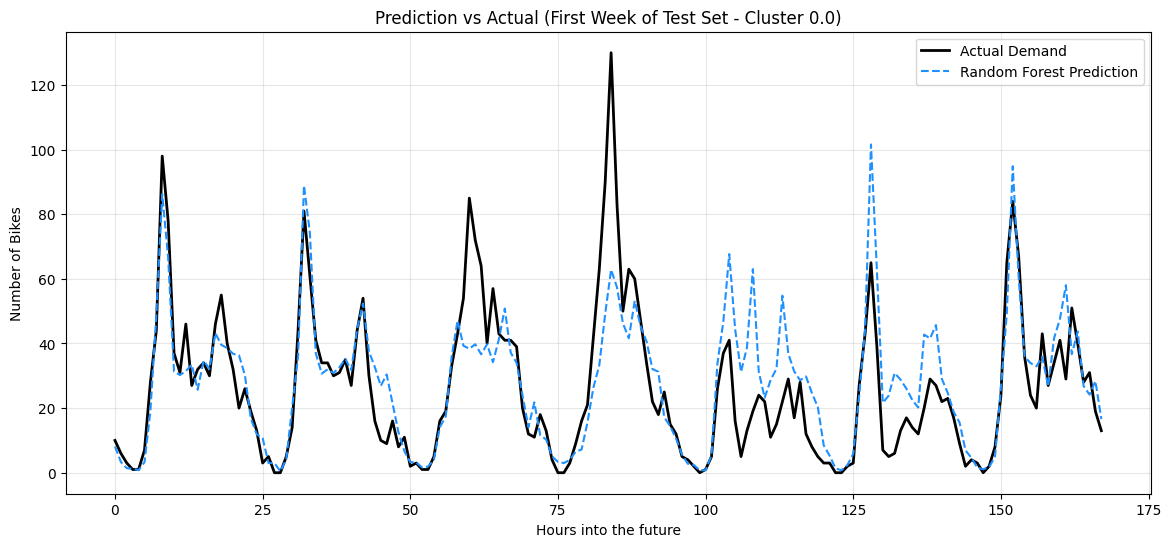

In [9]:
# --- VISUALIZATION OF PERFORMANCE ---
import matplotlib.pyplot as plt

# 1. Select specific data to plot
# Let's look at the FIRST CLUSTER in the test set
test_cluster_id = df_clean['cluster_id'].unique()[0] 

# Filter predictions for this cluster
# (We need to access the 'results' dictionary we created in the previous step)
y_test_actual = results['pickups']['actual']
y_test_pred = results['pickups']['pred']

# Create a mini-dataframe just for plotting
plot_df = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_test_pred,
    'Cluster': X_test['cluster_id'] # recover the cluster ID
})

# Filter for just one cluster and just the first week of November (Test Data)
subset = plot_df[plot_df['Cluster'] == test_cluster_id].iloc[:168] # 168 hours = 1 week

# 2. Plot
plt.figure(figsize=(14, 6))
plt.plot(subset.reset_index(drop=True).index, subset['Actual'], label='Actual Demand', color='black', linewidth=2)
plt.plot(subset.reset_index(drop=True).index, subset['Predicted'], label='Random Forest Prediction', color='dodgerblue', linestyle='--')

plt.title(f"Prediction vs Actual (First Week of Test Set - Cluster {test_cluster_id})")
plt.xlabel("Hours into the future")
plt.ylabel("Number of Bikes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 10. Time Series Decomposition
Decomposes the aggregated hourly demand into trend, seasonal, and residual components to analyze underlying patterns.

C:\Users\andre\AppData\Local\Temp\ipykernel_7652\2131545055.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_demand = df_clean.groupby('datetime')['pickups'].sum().asfreq('H').fillna(0)


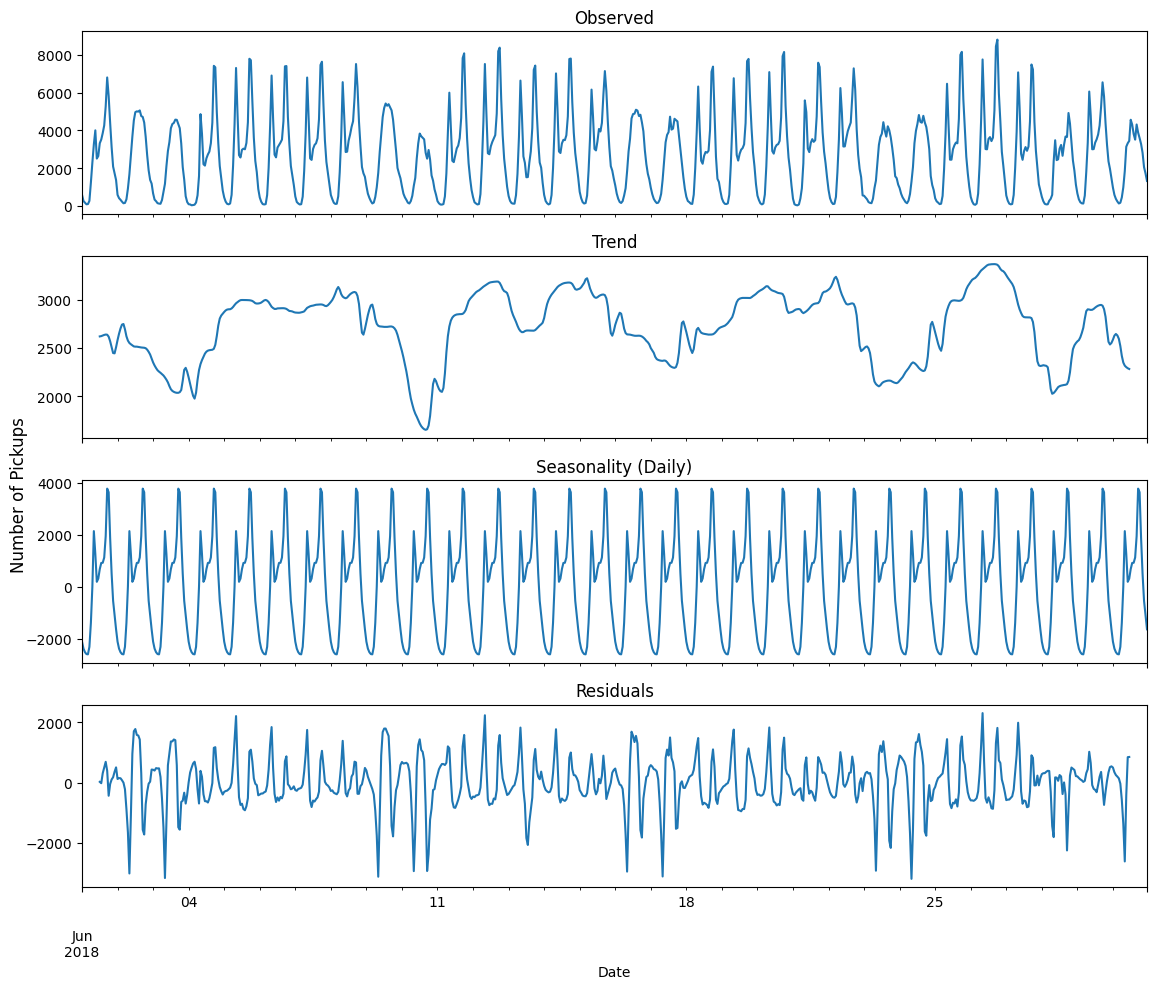

In [10]:
# For the data analysis part

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Prepare data: Aggregate TOTAL demand per hour (sum of all clusters)
# We use the 'df_clean' dataset we created earlier
hourly_demand = df_clean.groupby('datetime')['pickups'].sum().asfreq('H').fillna(0)

# 2. Decompose
# period=24 because we expect a daily cycle
# model='additive' because the amplitude of the cycles doesn't seem to grow exponentially with the trend
decomposition = seasonal_decompose(hourly_demand['2018-06-01':'2018-06-30'], model='additive', period=24)

# 3. Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonality (Daily)')
decomposition.resid.plot(ax=ax4, title='Residuals')

plt.xlabel('Date')

# Remove individual y-labels if they are auto-generated
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

# Set a common y-label for the whole figure
# x=0.04 controls horizontal position, y=0.5 centers it vertically
fig.text(0.04, 0.5, 'Number of Pickups', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
# Adjust layout to make room for the label
plt.subplots_adjust(left=0.1) 
plt.show()



### 11. Autocorrelation Analysis
Plots Autocorrelation (ACF) and Partial Autocorrelation (PACF) functions to identify significant lag relationships in the data.

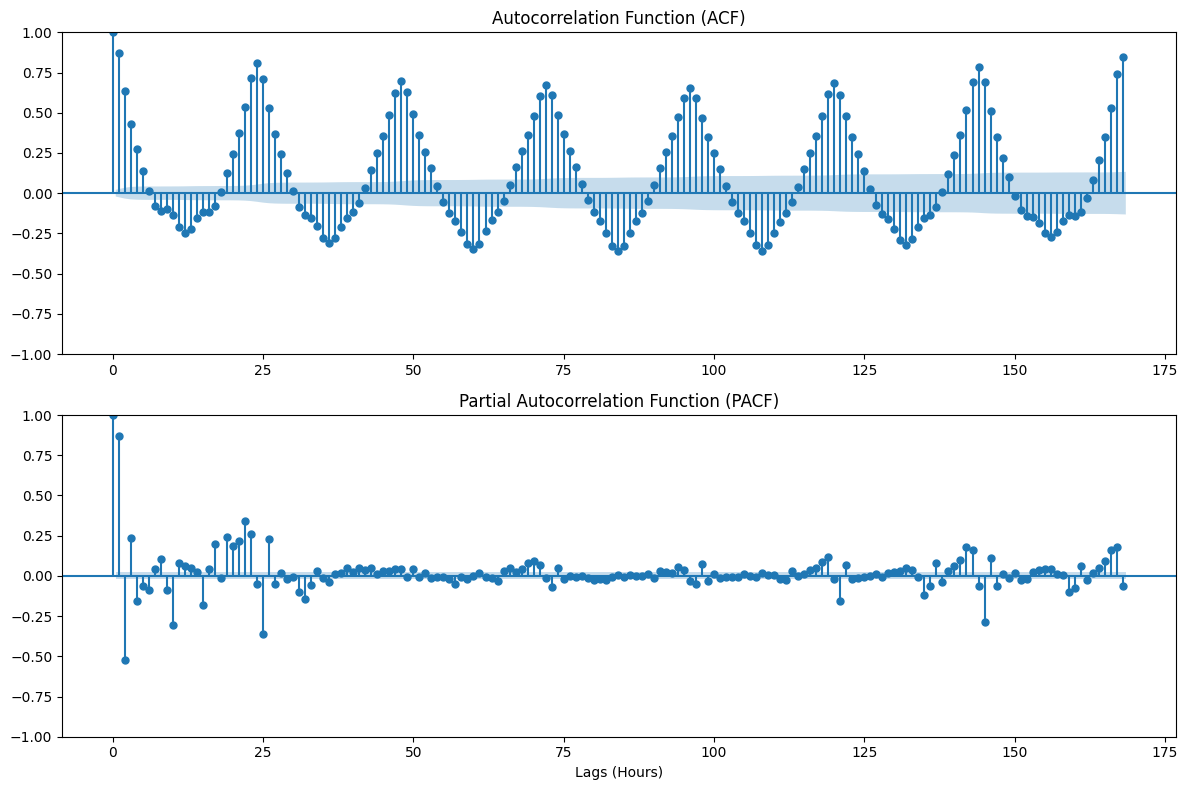

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation) - shows direct + indirect correlations
# We look at 1 week of lags (24 * 7 = 168 hours)
plot_acf(hourly_demand, lags=168, ax=ax1, title="Autocorrelation Function (ACF)")

# Plot PACF (Partial Autocorrelation) - shows ONLY direct correlations
plot_pacf(hourly_demand, lags=168, ax=ax2, title="Partial Autocorrelation Function (PACF)")

plt.xlabel('Lags (Hours)')
plt.tight_layout()
plt.show()